In [1]:
import pandas as pd
import re

In [2]:
def extract_chinese_words(text):
    pattern = r'([\u4e00-\u9fff]+)'  # 匹配中文字符的正则表达式
    matches = ''
    if type(text) == str:
        matches = re.findall(pattern, text)[0]
    return matches

## Zhihu

### answers

In [3]:
zh_answers = pd.read_csv('Scraper/zhihu/zhihu.csv')
print(len(zh_answers))
zh_answers = zh_answers.drop_duplicates('answer_id').rename(columns = {'texts':'post_content'})
zh_answers = zh_answers[~zh_answers['post_content'].isnull()]
zh_answers['author_location'] = zh_answers['author_location'].apply(lambda x: extract_chinese_words(x))
zh_answers['date'] = zh_answers['time_modified'].str[:10]
zh_answers['month'] = zh_answers['time_modified'].str[:7]
zh_answers['year'] = zh_answers['time_modified'].str[:4]
zh_answers['ID'] = 'zh_'+zh_answers['answer_id'].apply(str)
zh_answers['answer_content'] = 'None'
zh_answers['author_gender'] = zh_answers['author_gender'].replace({'Male':'m','Female':'f'})
zh_answers['platform'] = 'zhihu'
zh_answers['type'] = 'answers'
zh_answers['text_len'] = zh_answers['post_content'].apply(lambda x: len(x))
zh_answers['month_float'] = zh_answers['month'].apply(lambda x: float(x.replace('-', '.')))
print(len(zh_answers), zh_answers.columns)
zh_answers.to_csv('data/zhihu_answers.csv',index=False)

9534
9431 Index(['title', 'question_url', 'total_answers', 'index', 'post_content',
       'url', 'upvote_count', 'time_modified', 'comment_count', 'author_info',
       'author_gender', 'author_followers', 'author_following',
       'author_location', 'root_comment', 'answer_id', 'date', 'month', 'year',
       'ID', 'answer_content', 'platform', 'type', 'text_len', 'month_float'],
      dtype='object')


### comments

In [4]:
zh_comments = pd.read_csv('Scraper/zhihu/zhihu_comments.csv').rename(columns = {'answer_content':'post_content'})
print(len(zh_comments))
zh_comments = zh_comments.drop_duplicates('comment_id')
zh_comments['comment_content'] = zh_comments['comment_content'].replace(r'<[\/]?p>', '', regex=True)
zh_comments = zh_comments[~zh_comments['comment_content'].isnull()]
zh_comments['time'] = pd.to_datetime(zh_comments['created_time'], unit='s')
zh_comments['year'] = zh_comments['time'].dt.strftime('%Y')
zh_comments['month'] = zh_comments['year']+'-'+zh_comments['time'].dt.strftime('%m')
zh_comments['date'] = zh_comments['month']+'-'+zh_comments['time'].dt.strftime('%d')
zh_comments['url'] = zh_comments['question_url']+'/answer/'+zh_comments['answer_id'].apply(str)
zh_comments['ID'] = 'zhcm_'+zh_comments['comment_id'].apply(str)
zh_comments['platform'] = 'zhihu'
zh_comments['type'] = 'comments'
zh_comments['author_gender'] = zh_comments['author_gender'].replace({-1:'unknown',1:'m',0:'f'})
zh_comments['text_len'] = zh_comments['comment_content'].apply(lambda x: len(x))
zh_comments['month_float'] = zh_comments['month'].apply(lambda x: float(x.replace('-', '.')))
print(len(zh_comments), zh_comments.columns)
zh_comments.to_csv('data/zhihu_comments.csv',index=False)

18267
18061 Index(['title', 'question_url', 'answer_id', 'post_content', 'comment_id',
       'created_time', 'comment_content', 'comment_upvote',
       'child_comments_count', 'author_info', 'author_gender', 'time', 'year',
       'month', 'date', 'url', 'ID', 'platform', 'type', 'text_len',
       'month_float'],
      dtype='object')


## Weibo

In [5]:
weibo_box = pd.read_csv('Scraper/weibo/weibo_box.csv')
weibo_box['keywords'] = '女拳'
weibo_rights = pd.read_csv('Scraper/weibo/weibo.csv')
weibo_rights['keywords'] = '女权'

/Users/liaoyufang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
weibo = weibo_rights.append(weibo_box, ignore_index = True).rename(columns = {'text':'post_content'})
print(len(weibo))

472198


In [8]:
#remove reposts (considered as individual post before 2022)
weibo = weibo[~weibo['post_content'].isna()]
weibo = weibo[~weibo['post_content'].str.contains('//@')].drop_duplicates('mid')
weibo = weibo[weibo['time'].str.startswith('20')].reset_index(drop=True)
weibo['ID'] = 'wb_'+weibo['mid'].apply(str)

weibo['date'] = weibo['time'].str[:10]
weibo['month'] = weibo['time'].str[:7]
weibo['year'] = weibo['time'].str[:4]
weibo.loc[weibo['like'].isnull(), 'like'] = 0
weibo.loc[weibo['comment'].isnull(), 'comment'] = 0
weibo.loc[weibo['repost'].isnull(), 'repost'] = 0
weibo['answer_content'] = 'None'
weibo['platform'] = 'weibo'
weibo['type'] = 'posts'
weibo['text_len'] = weibo['post_content'].apply(lambda x: len(x))
weibo['month_float'] = weibo['month'].apply(lambda x: float(x.replace('-', '.')))
root_comment = pd.read_csv('Scraper/weibo/weibo_root_count.csv').append(pd.read_csv('Scraper/weibo/weibo_root_count_box.csv'))
weibo = weibo.merge(root_comment, how = 'left',left_on = 'mid', right_on = 'answer_id')
print(len(weibo),weibo.columns)
weibo.to_csv('data/weibo_posts.csv',index=False)

371064 Index(['mid', 'post_content', 'time', 'favorite', 'like', 'comment', 'repost',
       'author_uid', 'author_url', 'author_following', 'author_followers',
       'author_gender', 'author_location', 'keywords', 'ID', 'date', 'month',
       'year', 'answer_content', 'platform', 'type', 'text_len', 'month_float',
       'answer_id', 'root_comment'],
      dtype='object')


In [9]:
weibo = pd.read_csv('data/weibo_posts_moral.csv')
weibo = weibo[((weibo['post_content'].str.contains('女权'))|(weibo['post_content'].str.contains('女權'))|(weibo['post_content'].str.contains('女拳')))]
weibo.to_csv('data/weibo_posts_moral.csv',index=False)

<AxesSubplot:xlabel='month'>

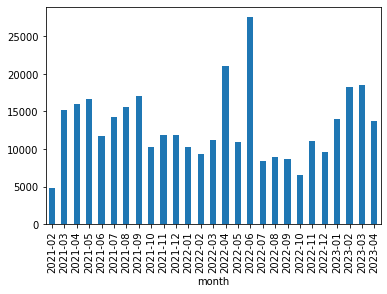

In [10]:
weibo.groupby('month')['year'].count().plot.bar()

In [11]:
mon2num = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
           'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}

In [12]:
weibo_comments_box = pd.read_csv('Scraper/weibo/weibo_comments_box.csv')
weibo_comments_box['keywords'] = '女拳'

weibo_comments_right = pd.read_csv('Scraper/weibo/weibo_comments.csv')
weibo_comments_right['keywords'] = '女权'

In [13]:
weibo_comments = weibo_comments_right.append(weibo_comments_box, ignore_index = True).rename(columns = {'answer_content':'post_content'})

In [14]:
# remove empty and duplicates
weibo_comments = weibo_comments.merge(weibo[['mid','author_uid']],how = 'left', left_on = 'answer_id', right_on = 'mid')
weibo_comments = weibo_comments[~weibo_comments['comment_content'].isna()]
weibo_comments = weibo_comments[~weibo_comments['answer_id'].isna()]
weibo_comments = weibo_comments[~weibo_comments['comment_content'].str.contains('//@')]
weibo_comments = weibo_comments[~weibo_comments['comment_content'].str.startswith('图片评论')]
weibo_comments = weibo_comments[~weibo_comments['comment_content'].str.startswith('转发微博')]
weibo_comments = weibo_comments[~(weibo_comments['comment_content'] == ' ')]

weibo_comments = weibo_comments.drop_duplicates('comment_id').reset_index(drop=True)
weibo_comments['ID'] = 'wbcm_'+weibo_comments['comment_id'].apply(str)

weibo_comments['year'] = weibo_comments['created_time'].str[-4:]
weibo_comments['month'] = weibo_comments['year']+'-'+weibo_comments['created_time'].str[4:7].replace(mon2num)
weibo_comments['date'] = weibo_comments['month']+'-'+weibo_comments['created_time'].str[8:10]
weibo_comments['platform'] = 'weibo'
weibo_comments['type'] = 'comments'
weibo_comments['text_len'] = weibo_comments['comment_content'].apply(lambda x: len(x))
weibo_comments['month_float'] = weibo_comments['month'].apply(lambda x: float(x.replace('-', '.')))
len(weibo_comments)

576094

should have done this before, but didn't realize this problem, and rerunning the moralization measurement is really time consuming

In [15]:
weibo_comments.to_csv('data/weibo_comments.csv',index=False)

In [ ]:
weibo_comments = pd.read_csv('Scraper/data/weibo_comments_moral.csv')
weibo_comments = weibo_comments[((weibo_comments['post_content'].str.contains('女权'))|(weibo_comments['post_content'].str.contains('女權'))|(weibo_comments['post_content'].str.contains('女拳')))]